# MVA RecVis 2020 - Assignment 3: Bird image classification competition

### BOUATAY Wassim

## Import libraries and Mount the drive

In [1]:
from google.colab import drive
import os
import warnings 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


from tqdm import tqdm
warnings.simplefilter("ignore")

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess and Visualize Data

#### **Adding more images to the validation-set**

In [2]:
path_data = '/content/drive/My Drive/bird_dataset'

for entry in os.listdir(path_data+"/train_images"):
  train_entry = path_data+"/train_images/"+entry
  nbr_train = len(os.listdir(train_entry))
  val_entry = path_data+"/val_images/"+entry
  nbr_val = len(os.listdir(val_entry))
  i = max(0, int ((nbr_train+nbr_val)*0.20-nbr_val)) ## splitting almost 80%-20%
  print("nbr of moved images", i)
  for image in os.listdir(train_entry):
    if i>0:
      shutil.move(train_entry+"/"+image, val_entry+"/"+image)
      i = i-1
    else:
      break

nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0
nbr of moved images 0


#### **Crop Images using Faster RCNN**

In [3]:
FRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FRCNN.eval().to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
])

def get_box(image, model, label=16):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    argmax = -1
    threshold = 0.6
    for i in range(len(outputs[0]['labels'])):
      if outputs[0]['labels'][i].item() == 16:
        if outputs[0]['scores'][i].item()>=threshold:
          threshold = outputs[0]['scores'][i].item()
          argmax = i

    if argmax == -1: ## No birds case
      return None
    return outputs[0]['boxes'][argmax]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [4]:
'''
for entry in os.listdir(path_data+"/train_images"):
  train_entry = path_data+"/train_images/"+entry
  print(entry)
  for path_image in os.listdir(train_entry):
    path_image = train_entry+'/'+path_image
    image = Image.open(path_image)
    size = image.size
    box = get_box(image, FRCNN)
    if box !=None:
      box = (max(int(box[0])-25,0), max(int(box[1])-25,0), min(int(box[2])+25,size[0]), min(int(box[3])+25, size[1]))
      cropped_img = image.crop(box)
      cropped_img.save(path_image)


for entry in os.listdir(path_data+"/val_images"):
  print(entry)
  train_entry = path_data+"/val_images/"+entry
  for path_image in os.listdir(train_entry):
    path_image = train_entry+'/'+path_image
    image = Image.open(path_image)
    size = image.size
    box = get_box(image, FRCNN)
    if box !=None:
      box = (max(int(box[0])-25,0), max(int(box[1])-25,0), min(int(box[2])+25,size[0]), min(int(box[3])+25, size[1]))
      cropped_img = image.crop(box)
      cropped_img.save(path_image)
'''

'\nfor entry in os.listdir(path_data+"/train_images"):\n  train_entry = path_data+"/train_images/"+entry\n  print(entry)\n  for path_image in os.listdir(train_entry):\n    path_image = train_entry+\'/\'+path_image\n    image = Image.open(path_image)\n    size = image.size\n    box = get_box(image, FRCNN)\n    if box !=None:\n      box = (max(int(box[0])-25,0), max(int(box[1])-25,0), min(int(box[2])+25,size[0]), min(int(box[3])+25, size[1]))\n      cropped_img = image.crop(box)\n      cropped_img.save(path_image)\n\n\nfor entry in os.listdir(path_data+"/val_images"):\n  print(entry)\n  train_entry = path_data+"/val_images/"+entry\n  for path_image in os.listdir(train_entry):\n    path_image = train_entry+\'/\'+path_image\n    image = Image.open(path_image)\n    size = image.size\n    box = get_box(image, FRCNN)\n    if box !=None:\n      box = (max(int(box[0])-25,0), max(int(box[1])-25,0), min(int(box[2])+25,size[0]), min(int(box[3])+25, size[1]))\n      cropped_img = image.crop(box)\n 

#### **prepare transforms and loaders**

In [5]:
# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 64 x 64 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set

img_size = 300
data_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30, fill=None),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


nclasses = 20
batch_size = 64


# Data initialization and loading
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/train_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/val_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


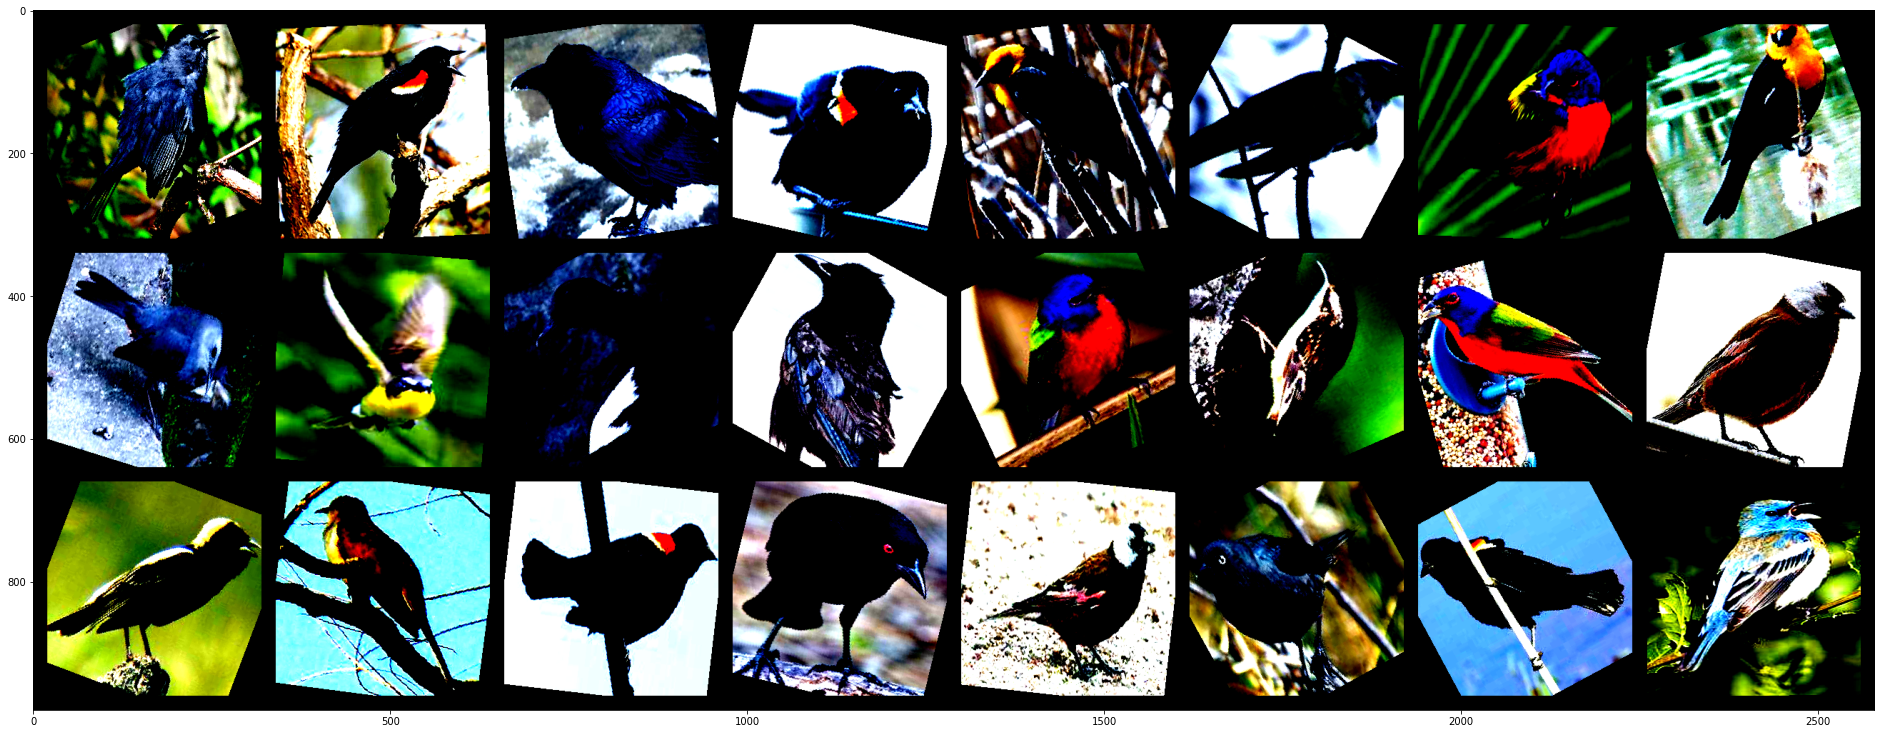

[[ 9  2 15  2  4 18  8  4]
 [ 9 10 12 16  8 14  8 19]
 [ 5 17  2 13 19  3  2  7]]


In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
fig = plt.figure(figsize = (33,13))
imshow(torchvision.utils.make_grid(images[0:24], padding=20))
print(np.array(labels[0:24]).reshape((-1,8)))

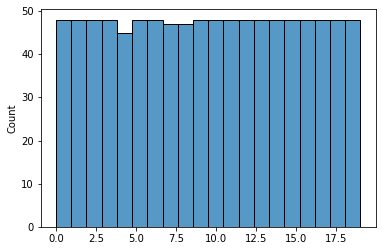

In [7]:
train_targets = train_loader.dataset.targets
sns.histplot(train_targets, bins=nclasses)

In [8]:
print(len(train_targets))
print(len(val_loader.dataset.targets))

955
230


## Model

In [9]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

def ResNet_model(nbr_models = 5):
    modelss = []
    for i in range(nbr_models):
      model = models.resnet50(pretrained=True)

      ct = 0
      for name, child in model.named_children():
          ct += 1
          if ct < 7:
              for name2, params in child.named_parameters():
                params.requires_grad = False
          else:
            break

      #for param in model.parameters():
      #  param.requires_grad = False
            
      num_param = model.fc.in_features
      model.fc = torch.nn.Sequential(
                      torch.nn.Linear(num_param, 64),
                      torch.nn.ReLU(),
                      torch.nn.Linear(64, nclasses)
                  )
      modelss.append(model)
    return modelss

In [10]:
experiment = 'experiment'

use_cuda = torch.cuda.is_available()
seed = 1
torch.manual_seed(seed)

# Create experiment folder
if not os.path.isdir(experiment):
    os.makedirs(experiment)

# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
#model = Net(kernel_size=5)  

def train(model, epoch, optimizer, log_interval=1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    if epoch % log_interval == 0:
       print('\nTrain Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.data.item()))   

def validation(model, epoch, log_interval=1):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_accuracy = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    if epoch % log_interval == 0:
      print('Validation set: Average loss: {:.4f}, Accuracy: ({:.2f}%)'.format(
          validation_loss, validation_accuracy))
    return validation_accuracy

In [11]:
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)

# Training settings
epochs = 100
LR_patience = 5

def training(model, config, log_interval=1, model_nbr=1):
  if use_cuda:
      model.cuda()

  optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',
                                                 factor=config['LR_factor'], 
                                                 patience = LR_patience,
                                                 verbose = False)
  accuracy = []
  best_acc = 0 
  early_stopping_after = 25
  for epoch in range(1, epochs + 1):
      train(model, epoch, optimizer, log_interval)
      acc = validation(model, epoch, log_interval)
      accuracy.append(acc)
      scheduler.step(acc)
      model_file = 'experiment/model'+str(model_nbr)+'.pth'
      if acc > best_acc:
        torch.save(model.state_dict(), model_file)
        best_acc = acc
        early_stopping_after = 25
      else:
        early_stopping_after -= 1 
      
      if early_stopping_after==0:
        print("Early Stopping at epoch", epoch)
        break

  return best_acc.item(), accuracy

#### **fine-tuning**

In [12]:
config = {'lr':0.006, 'momentum':0.8, 'LR_factor':0.8}
best_acc = 0
best_config = {'lr':0.006, 'momentum':0.8, 'LR_factor':0.8}

'''
dummy_model = ResNet_model(nbr_models=1)[0]
for config['lr'] in [0.004, 0.006, 0.008]:
  for config['momentum'] in [0.75, 0.8, 0.85]:
    for config['LR_factor'] in [0.8]:
      print("\n-------- LR={} ----- momentum={} ----- LR_factor={} -------".format(config['lr'], config['momentum'], config['LR_factor']))
      cum_acc = 0
      for i in range(3):
        acc = training(dummy_model, config, epochs+1)[0]
        print(acc)
        cum_acc += acc
      if (cum_acc/3 > best_acc ):
        best_acc = cum_acc/3
        best_config = {'lr':config['lr'], 'momentum':config['momentum'], 'LR_factor':config['LR_factor']}
      print("\n---->", cum_acc/3, "\n")

print("\n\nBest accuracy =", best_acc)
print("Best config =", best_config)
'''

'\ndummy_model = ResNet_model(nbr_models=1)[0]\nfor config[\'lr\'] in [0.004, 0.006, 0.008]:\n  for config[\'momentum\'] in [0.75, 0.8, 0.85]:\n    for config[\'LR_factor\'] in [0.8]:\n      print("\n-------- LR={} ----- momentum={} ----- LR_factor={} -------".format(config[\'lr\'], config[\'momentum\'], config[\'LR_factor\']))\n      cum_acc = 0\n      for i in range(3):\n        acc = training(dummy_model, config, epochs+1)[0]\n        print(acc)\n        cum_acc += acc\n      if (cum_acc/3 > best_acc ):\n        best_acc = cum_acc/3\n        best_config = {\'lr\':config[\'lr\'], \'momentum\':config[\'momentum\'], \'LR_factor\':config[\'LR_factor\']}\n      print("\n---->", cum_acc/3, "\n")\n\nprint("\n\nBest accuracy =", best_acc)\nprint("Best config =", best_config)\n'

#### **Training**

In [13]:
number_of_models = 5
modelss = ResNet_model(number_of_models)

average_accuracy = 0
for i in range(len(modelss)):
  best_acc, accuracy = training(modelss[i], best_config, model_nbr=i+1)
  average_accuracy += best_acc
  print("###################################################")

print("-->", average_accuracy/number_of_models)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth




Train Epoch: 1 	Loss: 2.918499
Validation set: Average loss: 0.0510, Accuracy: (15.65%)

Train Epoch: 2 	Loss: 2.832114
Validation set: Average loss: 0.0486, Accuracy: (33.91%)

Train Epoch: 3 	Loss: 2.561204
Validation set: Average loss: 0.0440, Accuracy: (46.96%)

Train Epoch: 4 	Loss: 2.200626
Validation set: Average loss: 0.0361, Accuracy: (55.65%)

Train Epoch: 5 	Loss: 1.808558
Validation set: Average loss: 0.0278, Accuracy: (64.78%)

Train Epoch: 6 	Loss: 1.210243
Validation set: Average loss: 0.0217, Accuracy: (72.17%)

Train Epoch: 7 	Loss: 0.947380
Validation set: Average loss: 0.0172, Accuracy: (76.96%)

Train Epoch: 8 	Loss: 0.658732
Validation set: Average loss: 0.0145, Accuracy: (80.43%)

Train Epoch: 9 	Loss: 0.633614
Validation set: Average loss: 0.0128, Accuracy: (82.17%)

Train Epoch: 10 	Loss: 0.407773
Validation set: Average loss: 0.0112, Accuracy: (83.04%)

Train Epoch: 11 	Loss: 0.493329
Validation set: Average loss: 0.0106, Accuracy: (83.48%)

Train Epoch: 12 	

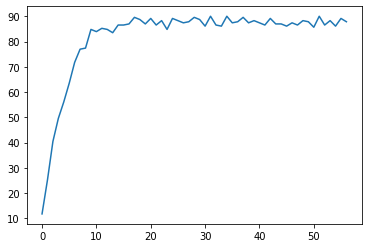

In [14]:
plt.plot(range(len(accuracy)) , accuracy)

## Evaluate 

In [15]:
from tqdm import tqdm
import os
import PIL.Image as Image
import torch

use_cuda = torch.cuda.is_available()

modelss = ResNet_model(number_of_models)
for i in range(len(modelss)):
  model = modelss[i]
  state_dict = torch.load('experiment/model'+str(i+1)+'.pth')
  model.load_state_dict(state_dict)
  model.eval()

  if use_cuda:
      print('Using GPU')
      model.cuda()
  else:
      print('Using CPU')

test_dir = path_data + '/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open('experiment/kaggle.csv', "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        image = pil_loader(test_dir + '/' + f)
        size = image.size
        box = get_box(image, FRCNN)
        if box !=None:
          box = (max(int(box[0])-25,0), max(int(box[1])-25,0), min(int(box[2])+25,size[0]), min(int(box[3])+25, size[1]))
          image = image.crop(box)
          
        data = test_data_transforms(image)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = 0
        for model in modelss:
          output += model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + 'experiment/kaggle.csv' + ', you can upload this file to the kaggle competition website')

Using GPU
Using GPU
Using GPU
Using GPU
Using GPU


100%|██████████| 517/517 [09:30<00:00,  1.10s/it]

Succesfully wrote experiment/kaggle.csv, you can upload this file to the kaggle competition website
